In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from empath import Empath

In [2]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [3]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]

In [4]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,year,month
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,2016,2
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,2016,2
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,2016,2
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,2016,2
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,2016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546081,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-16 11:12:00,zy88g,c68v8w5,"Google Fiber TV now includes Cartoon Network, ...",I would fear Google less because they have the...,google fiber tv now includes cartoon network c...,i would fear google less because they have the...,google fiber tv now includes cartoon network c...,2012,9
546082,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,2012,9
546083,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,2012,9
546084,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,2012,9


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis-embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [5]:
# Load saved embeddings
hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis-embeddings.pkl')

In [6]:
column = "thread_text_processed"
# column = "combined_processed"

In [7]:

texts = df[column].tolist()

# Generate embeddings in batches
batch_size = 10000
embeddings = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
    embeddings.append(batch_embeddings)

# Concatenate all batches
embeddings = torch.cat(embeddings, dim=0)

# Save text embeddings
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-embeddings.pkl', 'wb') as f:
    torch.save(embeddings, f)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\fahad\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fahad\.cache\huggingface\hub\models--Snowflake--snowflake-arctic-embed-s. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





README.md:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

C:\Users\fahad\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Processing batches: 100%|██████████| 55/55 [8:58:18<00:00, 587.24s/it]   


In [14]:
# Load saved embeddings
embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-embeddings.pkl')

In [8]:
# Initialize Empath
empath = Empath()
# Function to calculate empath categories
def get_empath_categories(text):
    categories = empath.analyze(text)
    return np.array([categories[cat] for cat in empath.cats.keys()])

In [12]:
# Calculate empath embeddings for hypotheses
hypothesis_empath_embeddings = np.array([get_empath_categories(hypothesis) for hypothesis in hypotheses])

# Save hypothesis empath embeddings
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_empath_embeddings.pkl', 'wb') as f:
    pickle.dump(hypothesis_empath_embeddings, f)

In [9]:
# Calculate empath embeddings for the dataset
empath_embeddings = []
tqdm.pandas(desc="Processing Empath Embeddings")
for empath_embedding in df['thread_text_processed'].progress_apply(lambda x: get_empath_categories(x)):
    empath_embeddings.append(empath_embedding)

# Save the empath embeddings to a file
with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-empath_embeddings.pkl', 'wb') as f:
    pickle.dump(empath_embeddings, f)

Processing Empath Embeddings: 100%|██████████| 546086/546086 [1:14:43<00:00, 121.80it/s]


In [17]:
# Load saved embeddings
# hypothesis_empath_embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_empath_embeddings.pkl')

# empath_embeddings = torch.load(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-empath_embeddings.pkl')

with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/hypothesis_empath_embeddings.pkl', 'rb') as f:
    hypothesis_empath_embeddings = pickle.load(f)

with open(f'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/models/{column}-empath_embeddings.pkl', 'rb') as f:
    empath_embeddings = pickle.load(f)

In [18]:
# Function to assign hypothesis based on both text and empath embeddings
def assign_hypothesis(text_embedding, empath_embedding, margin=0.03):
    text_similarities = cosine_similarity([text_embedding], hypothesis_embeddings).flatten()
    sorted_similarities = np.sort(text_similarities)[::-1]
    
    if sorted_similarities[0] - sorted_similarities[1] <= margin:
        empath_similarities = cosine_similarity([empath_embedding], hypothesis_empath_embeddings).flatten()
        combined_similarities = (text_similarities + empath_similarities) / 2
        return np.argmax(combined_similarities)
    return np.argmax(text_similarities)

In [19]:
# Assign hypotheses
tqdm.pandas(desc="Assigning Hypotheses")
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['hypothesis'] = [hypothesis_labels[assign_hypothesis(embeddings[i], empath_embeddings[i])] for i in tqdm(range(len(embeddings)))]


100%|██████████| 546086/546086 [04:19<00:00, 2103.37it/s]


In [20]:
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,year,month,hypothesis
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,2016,2,H2
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,2016,2,H2
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,2016,2,H0
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,2016,2,H4
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,2016,2,H4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546081,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-16 11:12:00,zy88g,c68v8w5,"Google Fiber TV now includes Cartoon Network, ...",I would fear Google less because they have the...,google fiber tv now includes cartoon network c...,i would fear google less because they have the...,google fiber tv now includes cartoon network c...,2012,9,H2
546082,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,2012,9,H2
546083,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,2012,9,H2
546084,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,2012,9,H2


hypothesis
H2    203291
H3    122681
H4     87229
H1     72408
H0     60477
Name: count, dtype: int64


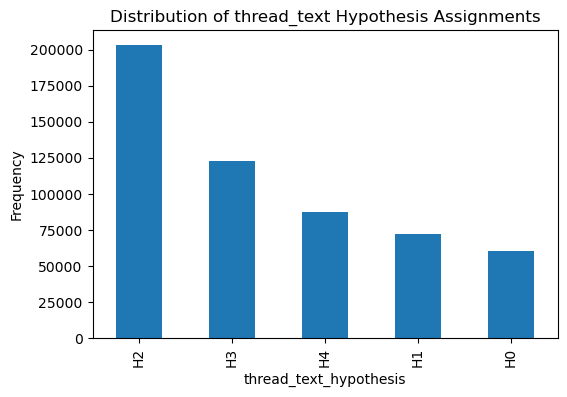

In [21]:
# Optional: Display a histogram of the assigned hypotheses
print(df['hypothesis'].value_counts())
df['hypothesis'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Distribution of thread_text Hypothesis Assignments')
plt.xlabel('thread_text_hypothesis')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Save the DataFrame with the hypothesis mapping
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_with_hypotheses.csv', index=False)